# Benchmark: Schoof in-house dataset

In [55]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


In [56]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Data loading

Let's define the path to the data and load it into anndata.

In [57]:
DATA_DIR = "../../data/processed/"

DATA_PATH = os.path.join(DATA_DIR, "schoof_protein_pca.h5ad")

In [58]:
adata = sc.read_h5ad(DATA_PATH)

adata.layers["raw_sn"] = adata.layers["log2_raw_sn"].copy()
adata.layers["raw_sn"][np.isnan(adata.layers["median_ratios"])] = np.nan

adata.X = adata.layers["raw_sn"].copy()

In [59]:
adata

AnnData object with n_obs × n_vars = 2541 × 1034
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-W', 'FSC-H', 'SSC-A', 'SSC-W', 'SSC-H', 'CD38 FACS', 'EMCN FACS', 'CD34 FACS', 'Lineage Cocktail FACS', 'CD123 FACS', 'CD90 FACS', 'CD49f FACS', 'CD45RA FACS', 'CD10 FACS', 'Time', 'Gated Population', 'Gate Path', 'QC leiden', 'Pass Cluster Filter', 'Individual', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'log2_sum_filter', 'leiden', 'Cluster Label', 'domain', 'cell_type', 'cell_type_confidence', 'phase', 'phase_confidence'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells', 'Matching Accession', 'Matched ENSG', 'Gene Symbol Protein', 'Gene Symbol RNA', 'Gene Symbol Combined', 'max_fold_change', 'Cluster'
    uns: 'Channel_colors', 'Cluster Label_colors', 'Column_colors', 'Gated Population_colo

## Data Exploration

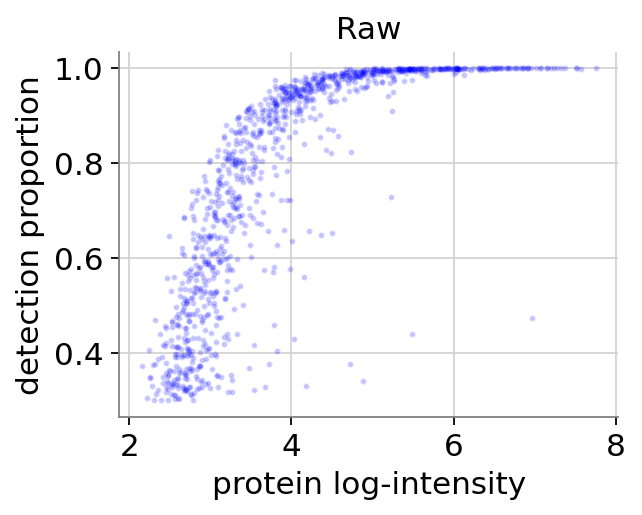

In [60]:
pl.scatter_protein_detection_proportion_and_intensity(adata.X, title="Raw")

In [61]:
print(f"nan intensities: {np.isnan(adata.layers['raw_sn']).sum() / (adata.shape[0] * adata.shape[1]) * 100:.2f}%")

nan intensities: 23.64%


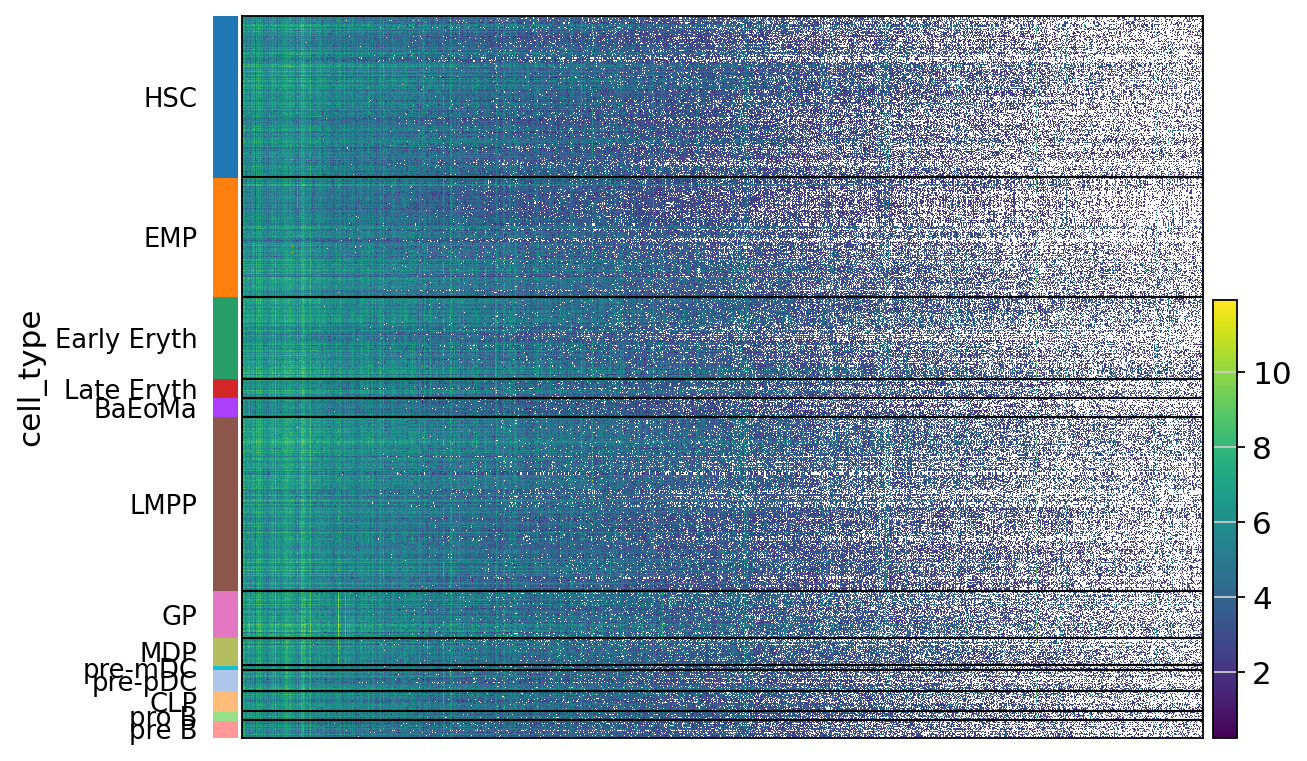

In [62]:
adata2 = utils.sort_anndata_by_missingness(adata, layer="raw_sn")


sc.pl.heatmap(adata2, layer="raw_sn", var_names=adata2.var_names, groupby="cell_type", show_gene_labels=False)

In [63]:
protein_missingness = utils.get_missingness_per_protein(adata2, layer="raw_sn")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 6.58%


In [91]:
adata.X = bm.impute_knn(adata, layer="raw_sn")

In [97]:
sc.pp.combat(adata, key="Plate")

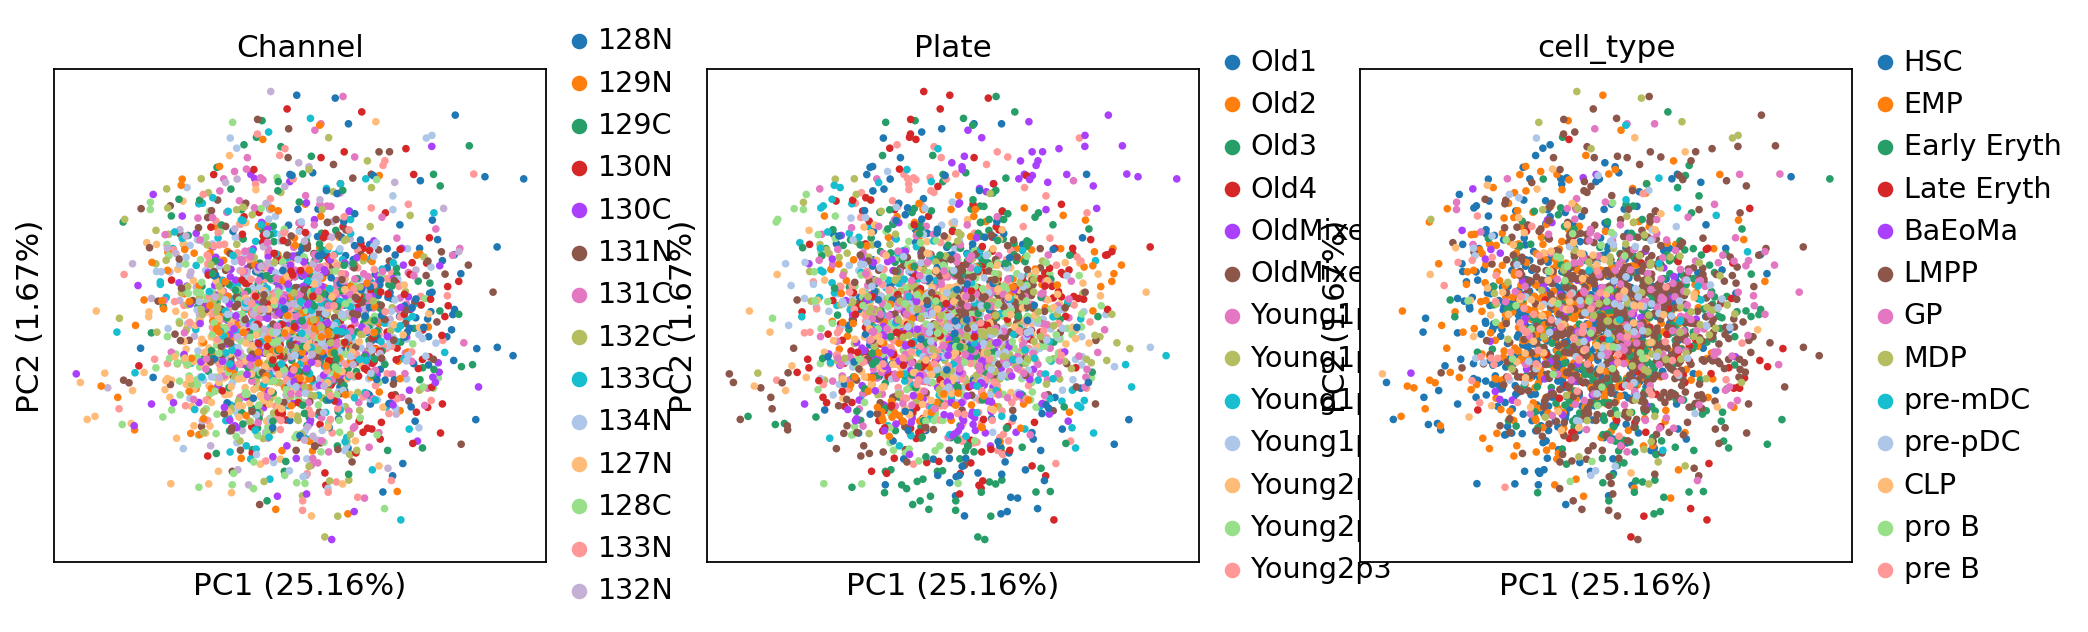

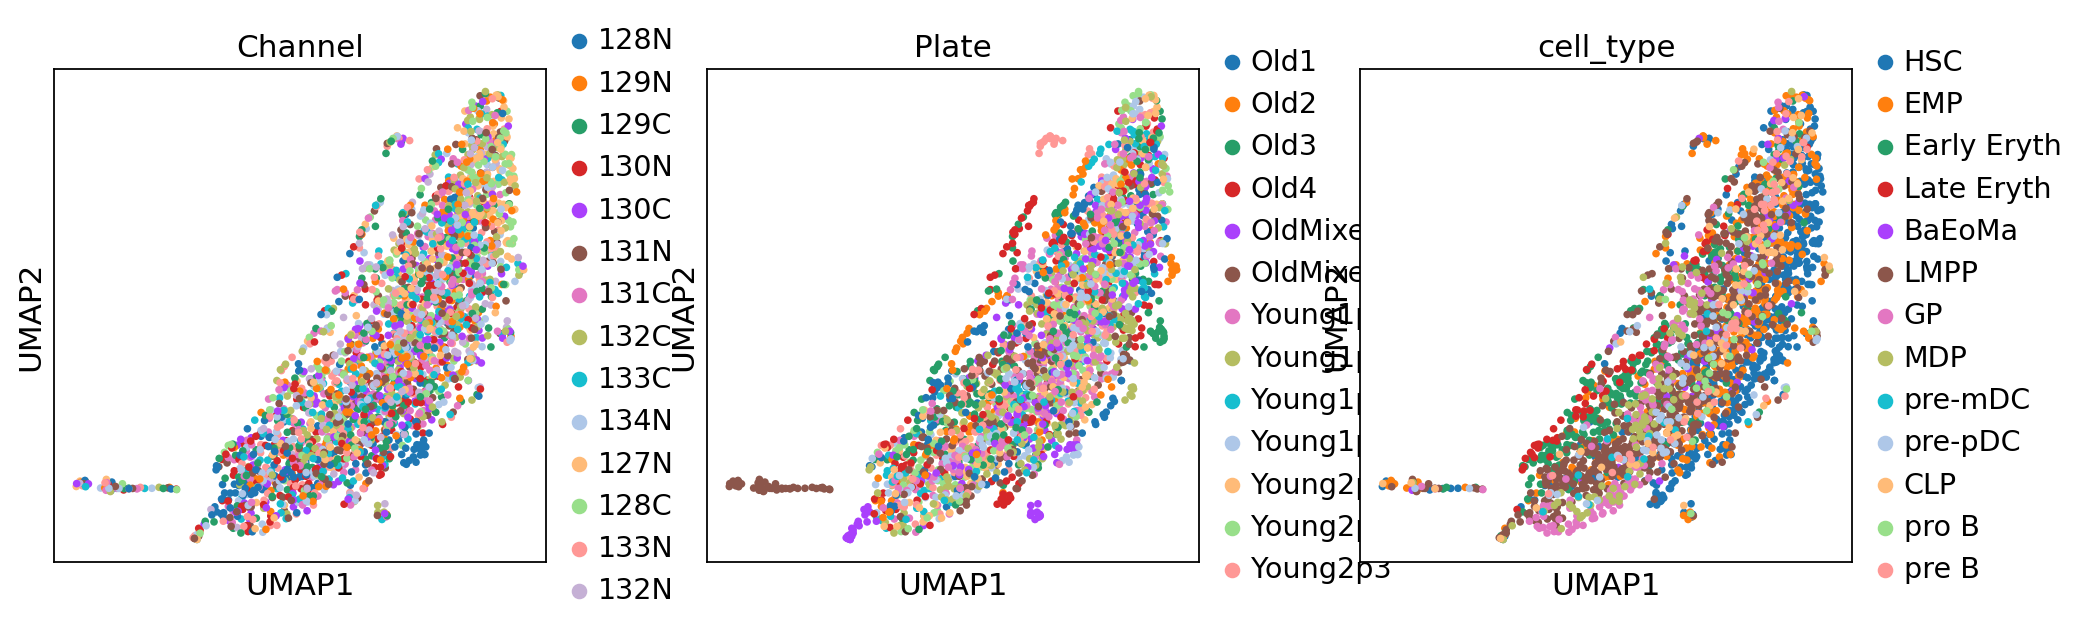

In [98]:
sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["Channel", "Plate", "cell_type"],
    components=["1,2"],
)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["Channel", "Plate", "cell_type"],
)

In [99]:
adata = adata[adata.obs["cell_type"].argsort()]

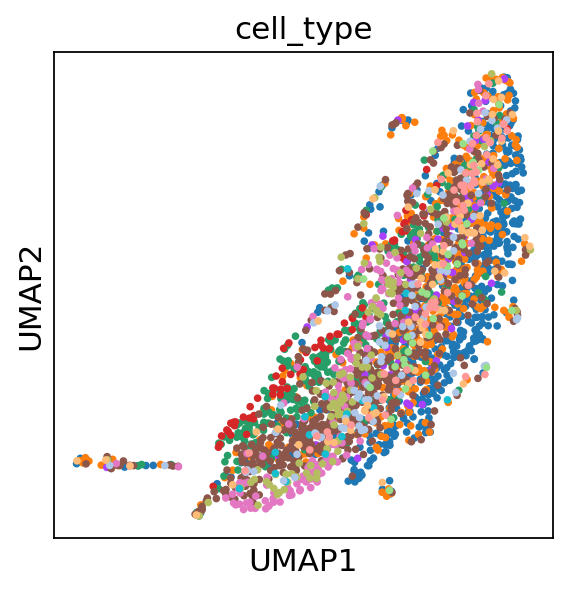

In [104]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(
        adata, 
        color=["cell_type"], 
        vmin="p01", vmax="p99",
        ncols=3,
        wspace=0.3,
    )

In [101]:
color_map = {
    "HSC": "blue",
    "EMP": "orange",
    "Early Eryth": "green",
    "Late Eryth": "red",
    "BaEoMa": "purple",
    "LMPP": "brown",
    "GP": "pink",
    "MDP": "olive",
    "pre-mDC": "cyan",
    "pre-pDC": "gray",
    "CLP": "orange",
    "pro B": "palegreen",
    "pre B": "tomato"
}

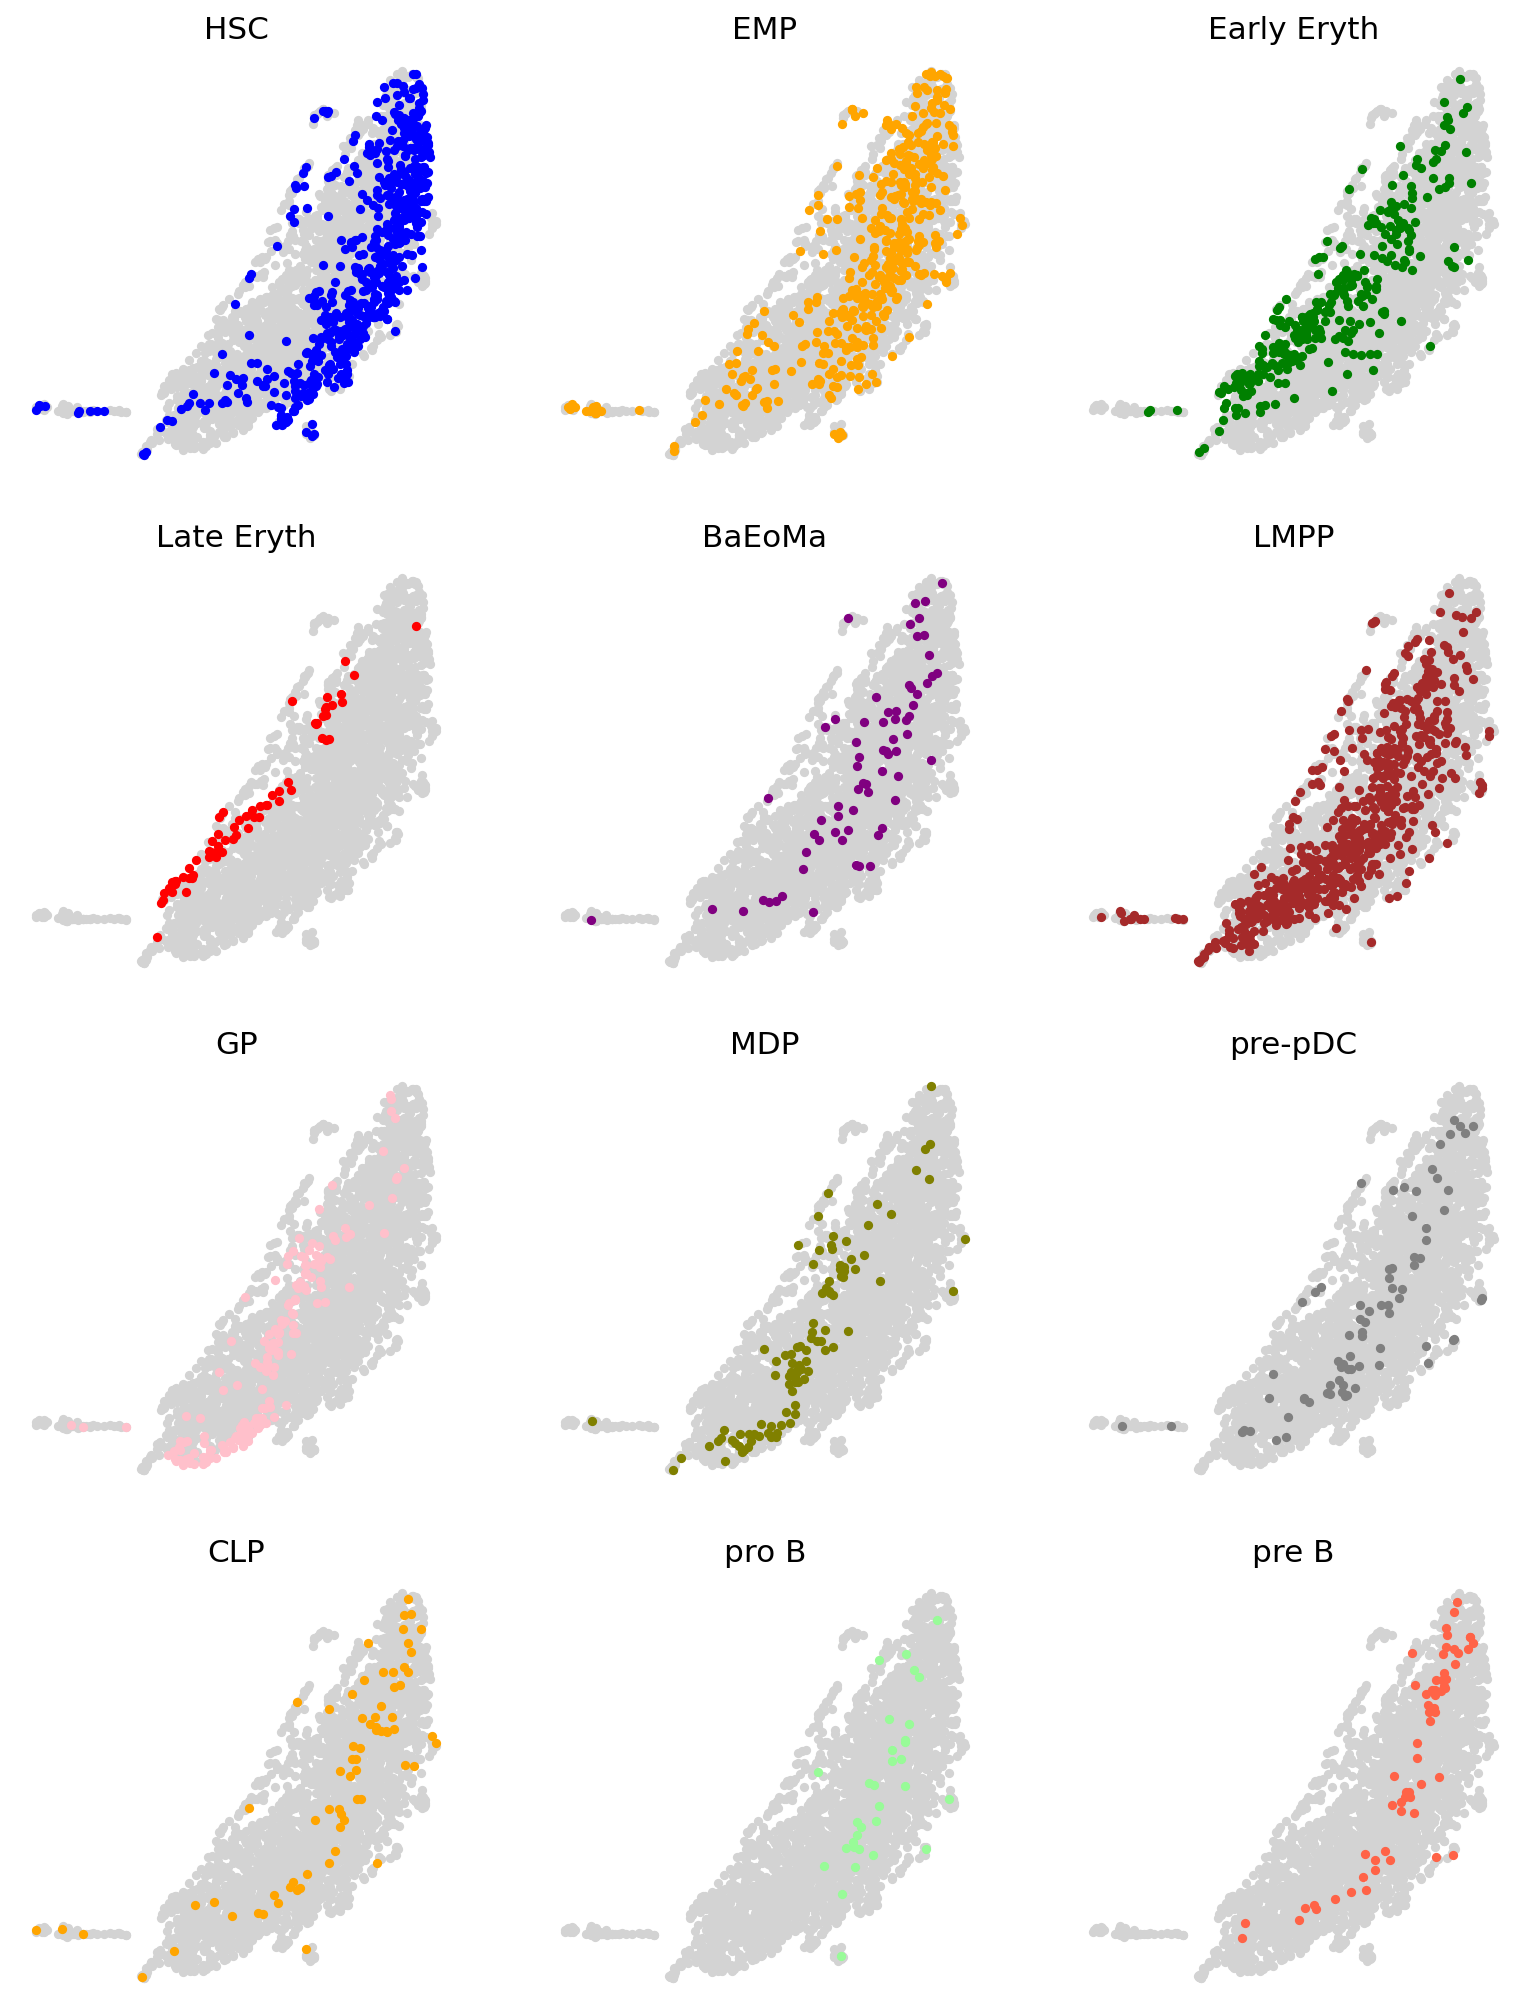

In [102]:
annotation = "cell_type"
categories = adata.obs[annotation].unique()
categories = categories[categories != "pre-mDC"]

n_elements = len(categories)

n_cols = 3
n_rows = n_elements // n_cols
n_rows += 1 if n_elements % n_cols != 0 else 0

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

colors = sns.color_palette("Set1", n_colors=n_elements)

for i, group in enumerate(categories):
    mask = adata.obs[annotation] == group

    ax = axes[i // n_cols, i % n_cols]

    umap = adata.obsm["X_umap"][~mask]

    ax.scatter(
        umap[:, 0],
        umap[:, 1],
        c = "lightgrey",
        s=10, 
    )

    umap = adata.obsm["X_umap"][mask]
    ax.scatter(
        umap[:, 0],
        umap[:, 1],
        c = color_map[group],
        s=10, 
    )

    ax.set_title(group, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

for i in range(n_elements, n_cols * n_rows):
    axes[i // n_cols, i % n_cols].axis("off")

fig.savefig("schoof_knn_pca_cell_type.png", bbox_inches="tight", dpi=200)